# Bench test of ADCP

This notebook demonstrates the effect of updating the firmware on the glider so that it sends the correct instruction to the ADCP on which beams to turn on.


The data from the two folders were collected before and after upgrading the firmware of SG637 from 66.12 DORADO to 66.12 EAGLECP

To conduct these tests, a glove full of water was placed over one sensor at a time for 30 second intervals. This started from the sensor nearest the nose of the glider on the odd minute and proceded clockwise around the sensors such that the glove was covering:

min:sec

01:00 - 01:30 **fore** (beam 1)

01:30 - 02:00 **port** (beam 2)

02:00 - 02:30 **aft** (beam 3)

02:30 - 03:00 **starboard** (beam 4)


In [1]:
import sys
import numpy as np
import pandas as pd
import copy
from netCDF4 import Dataset
from pathlib import Path
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
notebook_dir = !pwd # Replace with !echo %cd% if using windows
library_dir = Path(notebook_dir[0]).parent.absolute()
sys.path.append(str(library_dir))
data_raw_path = library_dir / 'data' / 'raw'

from src.data.adcp_mission_analysis import adcp_import_data, add_dive_averages, list_yos,read_glider_nc,  adcp_import_data, edgetocentre, centretoedge

from src.data.beam_mapping import beam2enu, beam_from_center, vert_miss

import matplotlib.pyplot as plt
from matplotlib import style
style_path = library_dir / 'src' / 'visualization' / 'presentation.mplstyle'
style.use(str(style_path))

In [2]:
def letterboxes(ax,loc=[0.05,0.85],nobox=False,box_alpha=0.5,offset=0):
    """
    For printing letters onto subplots. Defaults to the upper left corner
    Can take a replacement single location with the loc kwarg
    loc can be specified in pairs of x,y coordinates [[x1,y1],[x2,y2]] etc
    offset to start from another letter offset=2 to start from c etc.
    """
    if np.size(loc)==2:
        loc = np.tile(loc,(len(ax),1))
    loc = np.array(loc)
    for num in range(len(ax)):
        if nobox==False:
            ax[num].text(loc[num,0],loc[num,1],chr(num+97+offset),transform=ax[num].transAxes,
              bbox=dict(facecolor='white', edgecolor='none',alpha=box_alpha))
        else:
            ax[num].text(loc[num,0],loc[num,1],chr(num+97+offset),transform=ax[num].transAxes) 

In [3]:
dorado_path = Path('../data/dorado')
eagle_path = Path('../data/eagle')

In [4]:
dorado_overview, dorado_mission_dict = adcp_import_data(dorado_path)

/home/callum/anaconda3/envs/adcp-glider/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/media/callum/storage/Documents/adcp-glider/src/data/adcp_mission_analysis.py:457: RuntimeWarning: Mean of empty slice
  vel_referenced = vel - np.tile(np.nanmean(vel, 0) - ref_vel, (len(bin_centers), 1))


In [5]:
dorado_dive = dorado_mission_dict['0001a']
dorado_climb = dorado_mission_dict['0001b']

In [6]:
secs = np.arange(datetime(2020,8,3,14,1), datetime(2020,8,4,16,1), timedelta(seconds=30))
beam1 = secs[0::4]
beam2 = secs[1::4]
beam3 = secs[2::4]
beam4 = secs[3::4]

def beam_shade(ax):
    for beam_set in range(len(beam1)-1):
        ax.axvspan(beam1[beam_set], beam2[beam_set], alpha=0.3, color='C0')
        ax.axvspan(beam2[beam_set], beam3[beam_set], alpha=0.3, color='C1')
        ax.axvspan(beam3[beam_set], beam4[beam_set], alpha=0.3, color='C2')
        ax.axvspan(beam4[beam_set], beam1[beam_set+1], alpha=0.3, color='C3')
    ax.axvspan(beam1[0], beam2[0], alpha=0.3, color='C0',label='fore')
    ax.axvspan(beam2[0], beam3[0], alpha=0.3, color='C1',label='port')
    ax.axvspan(beam3[0], beam4[0], alpha=0.3, color='C2',label='aft')
    ax.axvspan(beam4[0], beam1[1], alpha=0.3, color='C3',label='stbd')

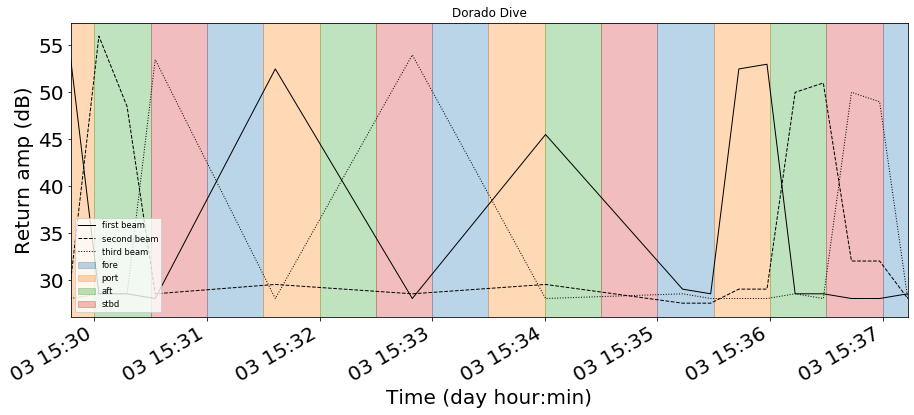

In [7]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(dorado_dive.time, dorado_dive.amp_beam[:,1,0], color='k', linestyle='-', label="first beam")
ax.plot(dorado_dive.time, dorado_dive.amp_beam[:,1,1], color='k', linestyle='--', label="second beam")
ax.plot(dorado_dive.time, dorado_dive.amp_beam[:,1,2], color='k', linestyle='dotted', label="third beam")
ax.set(xlim=[dorado_dive.time[0], dorado_dive.time[15]], xlabel='Time (day hour:min)',ylabel='Return amp (dB)', title='Dorado Dive')
fig.autofmt_xdate()
beam_shade(ax)
ax.legend(loc=3);
fig.savefig('../reports/bench_test_figures/dorado_dive.png')

From this we can see that the transducer not in use is the fore transducer. This is a dive limb, so not the behaviour we want

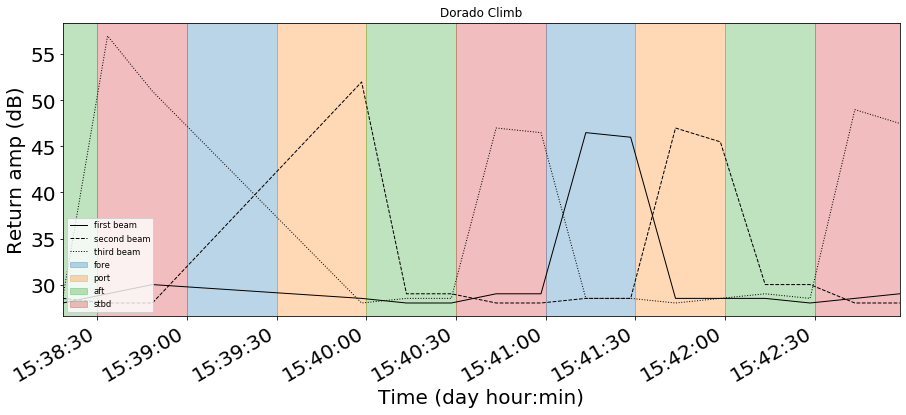

In [8]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(dorado_climb.time, dorado_climb.amp_beam[:,1,0], color='k', linestyle='-', label="first beam")
ax.plot(dorado_climb.time, dorado_climb.amp_beam[:,1,1], color='k', linestyle='--', label="second beam")
ax.plot(dorado_climb.time, dorado_climb.amp_beam[:,1,2], color='k', linestyle='dotted', label="third beam")
ax.set(xlim=[dorado_climb.time[0], dorado_climb.time[15]], xlabel='Time (day hour:min)',ylabel='Return amp (dB)', title='Dorado Climb')
fig.autofmt_xdate()
beam_shade(ax)
ax.legend(loc=3);
fig.savefig('../reports/bench_test_figures/dorado_climb.png')

On the climb limb, the aft transducer is disabled. Again this is the opposite behaviour to what we want

In [9]:
eagle_overview, eagle_mission_dict = adcp_import_data(eagle_path)
eagle_dive = eagle_mission_dict['0009a']
eagle_climb = eagle_mission_dict['0009b']


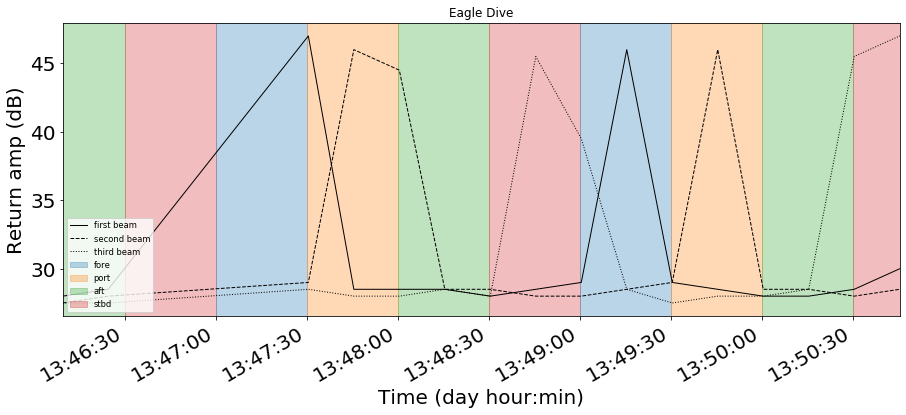

In [10]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(eagle_dive.time, eagle_dive.amp_beam[:,1,0], color='k', linestyle='-', label="first beam")
ax.plot(eagle_dive.time, eagle_dive.amp_beam[:,1,1], color='k', linestyle='--', label="second beam")
ax.plot(eagle_dive.time, eagle_dive.amp_beam[:,1,2], color='k', linestyle='dotted', label="third beam")
ax.set(xlim=[eagle_dive.time[0], eagle_dive.time[15]], xlabel='Time (day hour:min)',ylabel='Return amp (dB)', title='Eagle Dive')
fig.autofmt_xdate()
beam_shade(ax)
ax.legend(loc=3);
fig.savefig('../reports/bench_test_figures/eagle_dive.png')

With the new EAGLECP firmware, the glider turns the aft transducer off on the dive, as desired

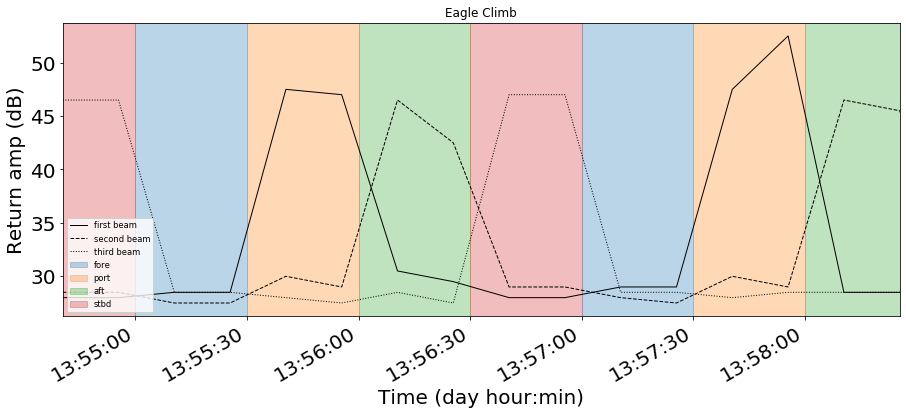

In [11]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(eagle_climb.time, eagle_climb.amp_beam[:,1,0], color='k', linestyle='-', label="first beam")
ax.plot(eagle_climb.time, eagle_climb.amp_beam[:,1,1], color='k', linestyle='--', label="second beam")
ax.plot(eagle_climb.time, eagle_climb.amp_beam[:,1,2], color='k', linestyle='dotted', label="third beam")
ax.set(xlim=[eagle_climb.time[0], eagle_climb.time[15]], xlabel='Time (day hour:min)',ylabel='Return amp (dB)', title='Eagle Climb')
fig.autofmt_xdate()
beam_shade(ax)
ax.legend(loc=3);
fig.savefig('../reports/bench_test_figures/eagle_climb.png')

The fore transducer is turned off during the climb

### The above plots combined in one figure

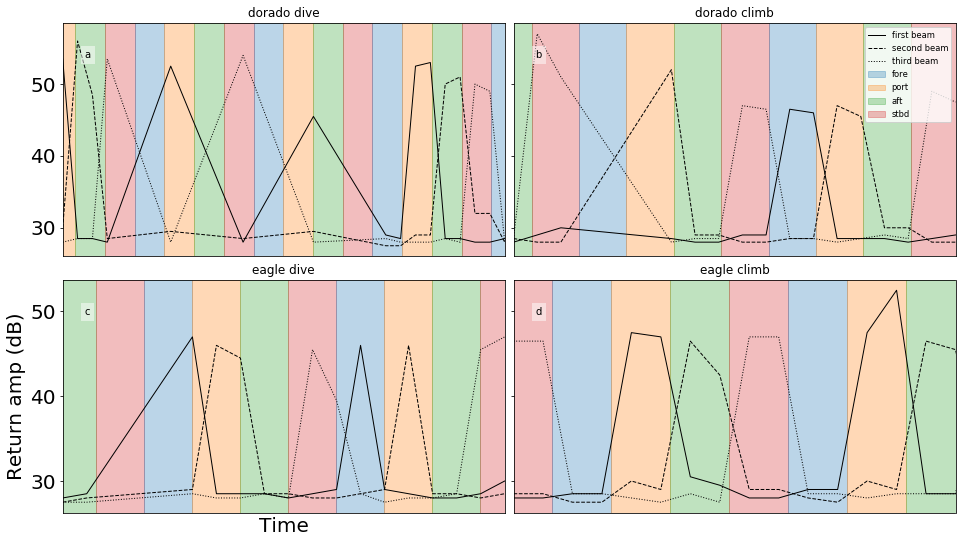

In [12]:
fig, ax = plt.subplots(2,2,figsize=(16,10), sharey='row', sharex=False)
fig.subplots_adjust(hspace=0.1, wspace=0.02)

ax = ax.ravel()
datasets = [dorado_dive, dorado_climb, eagle_dive, eagle_climb]
ds_names = ["dorado dive", "dorado climb", "eagle dive", "eagle climb"]
for ax_no, dataset in enumerate(datasets):
    ax[ax_no].plot(dataset.time, dataset.amp_beam[:,1,0], color='k', linestyle='-', label="first beam")
    ax[ax_no].plot(dataset.time, dataset.amp_beam[:,1,1], color='k', linestyle='--', label="second beam")
    ax[ax_no].plot(dataset.time, dataset.amp_beam[:,1,2], color='k', linestyle='dotted', label="third beam")
    ax[ax_no].set(xlim=[dataset.time[0], dataset.time[15]], xticks=[],title=ds_names[ax_no])
    beam_shade(ax[ax_no])
    fig.autofmt_xdate()
ax[2].set(xlabel='Time',ylabel='Return amp (dB)')
ax[1].legend(loc=1);
letterboxes(ax)
fig.savefig('../reports/bench_test_figures/transducer_tests.png')

### Beam miss variation with glider attitude

In [13]:
pitches = np.arange(4.8,30.2, 0.02)
rolls = np.arange(-10.2,10.2,0.02)
r2d, p2d = np.meshgrid(rolls,pitches)
d2d = np.ones(np.shape(p2d)) * 15.0
beam_miss_climb = beam_from_center(p2d, r2d, d2d)
beam_miss_dive = beam_from_center(-p2d, r2d, d2d)

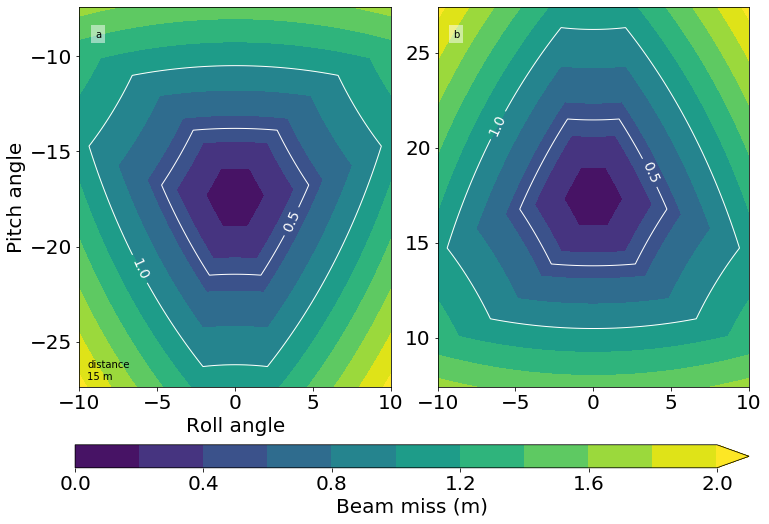

In [14]:
fig, ax = plt.subplots(1,2,figsize=(12,8))
fig.subplots_adjust(wspace=0.15)
lims = np.arange(0,2.1,0.2)
ax = ax.ravel()
f1 = ax[0].contourf(rolls, -pitches,beam_miss_dive, lims, extend='max')
f2 = ax[1].contourf(rolls, pitches,beam_miss_climb, lims, extend='max')
l1 = ax[0].contour(rolls, -pitches, beam_miss_dive, [0.5, 1.0], colors='w')
l2 = ax[1].contour(rolls, pitches, beam_miss_dive, [0.5, 1.0], colors='w')

ax[0].set(xlabel='Roll angle', ylabel = 'Pitch angle', ylim=[-27.4, -7.4], xlim=[-10, 10], yticks=np.arange(-25,-5,5))
ax[1].set(ylim=[7.4, 27.4], xlim=[-10, 10], yticks=np.arange(5,30,5))
ax[0].clabel(l1, inline=True, fontsize=14,  fmt='%1.1f')
ax[1].clabel(l2, inline=True, fontsize=14,  fmt='%1.1f')
ax[0].text(-9.5, -27, 'distance\n15 m')

fig.subplots_adjust(bottom=0.22)
cbar_ax = fig.add_axes([0.12, 0.08, 0.78, 0.04])

letterboxes(ax, loc=[0.05,0.92])
fig.colorbar(f1, cax=cbar_ax, label=r"Beam miss (m)", orientation='horizontal');
fig.savefig('../reports/bench_test_figures/beam_miss.png')